In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
# import preprocessed data
defensive_players = pd.read_csv('defensive_players.csv')

# Baseline

### No tackles

In [4]:
# Take number of no tackles / total number of players (predict 0 for everyone)
baseline_table = defensive_players['tackle_prob'].value_counts()
baseline_acc = baseline_table[0] / (baseline_table[0] + baseline_table[1])

print(f"Baseline of predicting no tackles is: {baseline_acc}")

# randomly would do worse than this

Baseline of predicting no tackles is: 0.9090667182737433


### Random tackle per play

In [3]:
# Group by playId and gameId and randomly predict player to make tackle
defensive_players_week7 = defensive_players[defensive_players['week']==7].copy()
baseline_predictions = defensive_players_week7.groupby(['gameId', 'playId']).apply(lambda group: group.sample(n=1)).copy()

# Create a new column 'tackle_prob' and set it to 1 for the sampled rows
baseline_predictions['tackle_pred'] = 1

# Reset index to remove hierarchical index
baseline_predictions_reset = baseline_predictions.reset_index(drop=True)

# Create a new DataFrame with all rows from defensive_players and merge with baseline_predictions_reset
all_rows = defensive_players_week7.merge(baseline_predictions_reset[['gameId', 'playId', 'nflId_defense', 'tackle_pred']], on=['gameId', 'playId', 'nflId_defense'], how='left')

# Fill NaN values with 0 in the tackle_prob column
all_rows['tackle_pred'].fillna(0, inplace=True)
all_rows[['gameId', 'playId', 'nflId_defense', 'tackle_prob', 'tackle_pred']]

,gameId,playId,nflId_defense,tackle_prob,tackle_pred
0,2022102000,56,44848.0,0,0.0
1,2022102000,56,47816.0,0,0.0
2,2022102000,56,47848.0,0,0.0
3,2022102000,56,49410.0,0,0.0
4,2022102000,56,52416.0,0,0.0
...,...,...,...,...,...
5473,2022102400,3556,52458.0,0,0.0
5474,2022102400,3556,52571.0,0,0.0
5475,2022102400,3556,54504.0,0,0.0
5476,2022102400,3556,54513.0,0,1.0


In [5]:
# Confusion matrix
conf_matrix_baseline = confusion_matrix(all_rows['tackle_prob'], all_rows['tackle_pred'])

# Display the confusion matrix
print("Confusion Matrix for Baseline:")
print(conf_matrix_baseline)

baseline_acc = (conf_matrix_baseline[0,0] + conf_matrix_baseline[1,1]) / (conf_matrix_baseline[0,0] + conf_matrix_baseline[0,1] + conf_matrix_baseline[1,0] + conf_matrix_baseline[1,1])

print(f"Baseline of predicting random tackles is: {baseline_acc}")

# Compute AUC
auc_roc = roc_auc_score(all_rows['tackle_prob'], all_rows['tackle_pred'])

# Displaying the results
print(f"AUC is: {auc_roc:}")

classification_report_result = classification_report(all_rows['tackle_prob'], all_rows['tackle_pred'])

print("Classification Report:\n", classification_report_result)

Confusion Matrix for Baseline:
[[4533  447]
 [ 447   51]]
Baseline of predicting random tackles is: 0.836801752464403
AUC is: 0.5063253012048192
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      4980
           1       0.10      0.10      0.10       498

    accuracy                           0.84      5478
   macro avg       0.51      0.51      0.51      5478
weighted avg       0.84      0.84      0.84      5478



### Person closest

In [10]:
defensive_players['week']

0        1
1        1
2        1
3        1
4        1
        ..
41333    7
41334    7
41335    7
41336    7
41337    7
Name: week, Length: 41338, dtype: int64

In [11]:
# Sort the DataFrame by "dist_to_bc" within each group

baseline_prediction_closest = defensive_players[defensive_players['week']==7].copy()
baseline_prediction_closest['tackle_pred'] = baseline_prediction_closest.groupby(['gameId', 'playId'])['dist_to_bc'].rank()

# Set "tackle_pred" to 1 for rows with the minimum value in each group, and 0 for others
baseline_prediction_closest['tackle_pred'] = baseline_prediction_closest['tackle_pred'].apply(lambda x: 1 if x == 1 else 0)

# # You can drop the additional column used for ranking if you want
# df = df.drop(columns=['dist_to_bc'])

# # If needed, you can sort the DataFrame by 'gameId' and 'playId'
# df.sort_values(['gameId', 'playId'], inplace=True)

# Reset index if necessary
baseline_prediction_closest.reset_index(drop=True, inplace=True)

baseline_prediction_closest[['gameId', 'playId', 'nflId_defense', 'tackle_prob', 'tackle_pred']]

# Check
# baseline_prediction_closest[(baseline_prediction_closest['gameId']==2022090800)&(baseline_prediction_closest['playId']==56)][['gameId', 'playId', 'nflId_defense', 'dist_to_bc','tackle_prob', 'tackle_pred']]



,gameId,playId,nflId_defense,tackle_prob,tackle_pred
0,2022102000,56,44848.0,0,0
1,2022102000,56,47816.0,0,0
2,2022102000,56,47848.0,0,0
3,2022102000,56,49410.0,0,0
4,2022102000,56,52416.0,0,0
...,...,...,...,...,...
5473,2022102400,3556,52458.0,0,0
5474,2022102400,3556,52571.0,0,0
5475,2022102400,3556,54504.0,0,1
5476,2022102400,3556,54513.0,0,0


In [12]:
# Confusion matrix
conf_matrix_baseline = confusion_matrix(baseline_prediction_closest['tackle_prob'], baseline_prediction_closest['tackle_pred'])

# Display the confusion matrix
print("Confusion Matrix for Baseline:")
print(conf_matrix_baseline)

baseline_acc = (conf_matrix_baseline[0,0] + conf_matrix_baseline[1,1]) / (conf_matrix_baseline[0,0] + conf_matrix_baseline[0,1] + conf_matrix_baseline[1,0] + conf_matrix_baseline[1,1])

print(f"Baseline of predicting random tackles is: {baseline_acc}")

# Compute AUC
auc_roc = roc_auc_score(baseline_prediction_closest['tackle_prob'], baseline_prediction_closest['tackle_pred'])

# Displaying the results
print(f"AUC is: {auc_roc:}")

Confusion Matrix for Baseline:
[[4802  178]
 [ 178  320]]
Baseline of predicting random tackles is: 0.9350127783862724
AUC is: 0.8034136546184739


# Feature Selection

### Remove columns - domain knowledge

In [205]:
# Columns to be removed
columns_to_remove = [
    'gameId', 'playId', 'frameId', 'time', 'event', 'season', 'club', 
    'gameDate', 'gameTimeEastern','gameClock','nflId_defense', 'nflId_offense', 
     'defensiveTeam',
    
    'homeFinalScore', 'visitorFinalScore', 'preSnapHomeScore', 'preSnapVisitorScore',
    'homeTeamAbbr', 'visitorTeamAbbr',
    
    'displayName_y','ballCarrierDisplayName','ballCarrierId', 'displayName_x_offense', 
    'displayName_x_defense','position_defense', 'position_role_defense', 
    'position_offense', 'position_role_offense',
    
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'tackle','prob_differential',
    'offense_win_prob', 'differential', 'is_defense','x_offense', 'x_defense','y_offense', 'y_defense',
    'dis_offense', 'dis_defense','passProbability', 'absoluteYardlineNumber',
    
    'a_defense', 's_defense', 's_offense', 'a_offense', 'forcedFumble', 'assist', 'pff_missedTackle'
    
#     'game_rolling_missed_tackle_ct','season_rolling_missed_tackle_ct', 'game_rolling_tackle_ct', 
#     'season_rolling_tackle_ct'
]

# Drop columns
defensive_players_filtered = defensive_players.drop(columns=columns_to_remove, errors='ignore')
defensive_players_filtered

# nflId_defense, nflId_offense, playDirection, week, position_group_defense, quarter, down, absoluteYardlineNumber, offenseFormation, defensiveTeam, position_offense

,playDirection,o_defense,dir_defense,week,height_in_inch_defense,weight_defense,position_group_defense,quarter,down,yardsToGo,time_remaining,passLength,offenseFormation,defendersInTheBox,season_rolling_tackle_ct,game_rolling_tackle_ct,season_rolling_missed_tackle_ct,game_rolling_missed_tackle_ct,o_offense,dir_offense,weight_offense,height_in_inch_offense,position_group_offense,offense_score,defense_score,defense_win_prob,dist_to_bc,num_blockers,total_weight_blockers,rank_to_bc,delta_x,delta_y,angle_to_offensive,resulting_velocity,resulting_acceleration,tackle_prob
0,left,349.47,357.71,1,72,242,LB,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,0.0,114.27,202.20,191,72,R,0,0,0.413347,7.067538,0,0,3.0,1.74,6.85,75.747473,0.694361,0.543052,0
1,left,186.16,157.65,1,73,280,DL,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,0.0,114.27,202.20,191,72,R,0,0,0.413347,13.527265,6,1742,9.0,-12.30,5.63,155.405313,3.617222,2.857805,0
2,left,331.57,278.33,1,71,184,DB,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,0.0,114.27,202.20,191,72,R,0,0,0.413347,29.415605,9,2438,11.0,9.23,27.93,71.712879,-2.324453,-3.701244,0
3,left,140.96,178.50,1,73,208,DB,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,0.0,114.27,202.20,191,72,R,0,0,0.413347,2.828003,0,0,1.0,1.70,-2.26,-53.049062,-3.656444,-0.764868,1
4,left,159.12,203.53,1,77,240,DL,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,0.0,114.27,202.20,191,72,R,0,0,0.413347,12.502404,4,1096,6.0,-12.26,2.45,168.699055,1.099927,1.814058,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41333,left,75.39,113.13,7,72,195,DB,4,1,10,224,0.0,SHOTGUN,4.0,5.0,2.0,1.0,0.0,118.05,162.22,246,72,HB,14,33,0.996346,10.191173,3,981,4.0,7.50,6.90,42.614056,1.544311,0.700444,0
41334,left,174.30,161.77,7,71,190,DB,4,1,10,224,0.0,SHOTGUN,4.0,9.0,1.0,1.0,0.0,118.05,162.22,246,72,HB,14,33,0.996346,33.685608,10,2732,11.0,13.39,-30.91,-66.578070,-1.003552,-1.488712,0
41335,left,101.52,128.75,7,72,195,DB,4,1,10,224,0.0,SHOTGUN,4.0,18.0,0.0,3.0,1.0,118.05,162.22,246,72,HB,14,33,0.996346,5.993630,0,0,1.0,5.94,0.80,7.670448,-3.422590,-0.660771,0
41336,left,118.83,174.90,7,73,202,DB,4,1,10,224,0.0,SHOTGUN,4.0,10.0,2.0,2.0,0.0,118.05,162.22,246,72,HB,14,33,0.996346,29.492041,9,2552,10.0,24.26,-16.77,-34.654606,-3.705714,-2.548766,0


### Create composite values

In [189]:
# # Create new columns for composite features
# defensive_players_filtered['height_dif'] = defensive_players_filtered['height_in_inch_defense'] - defensive_players_filtered['height_in_inch_offense']
# defensive_players_filtered['s_dif'] = defensive_players_filtered['s_defense'] - defensive_players_filtered['s_offense']
# defensive_players_filtered['dis_dif'] = defensive_players_filtered['dis_defense'] - defensive_players_filtered['dis_offense']
# defensive_players_filtered['weight_dif'] = defensive_players_filtered['weight_offense'] - defensive_players_filtered['weight_defense']

# # Drop the columns used to create the composite features
# columns_to_drop = ['height_in_inch_defense', 'height_in_inch_offense',
#                    's_defense', 's_offense',
#                    'dis_defense', 'dis_offense',
#                    'weight_offense', 'weight_defense']

# defensive_players_filtered_comp = defensive_players_filtered.drop(columns=columns_to_drop, axis=1)
# defensive_players_filtered_comp

In [139]:
defensive_players_filtered

,playDirection,s_defense,a_defense,o_defense,dir_defense,week,height_in_inch_defense,weight_defense,position_group_defense,quarter,down,yardsToGo,time_remaining,passLength,offenseFormation,defendersInTheBox,assist,forcedFumble,pff_missedTackle,s_offense,a_offense,o_offense,dir_offense,weight_offense,height_in_inch_offense,position_group_offense,offense_score,defense_score,defense_win_prob,dist_to_bc,rank_to_bc,tackle_prob
0,left,3.35,2.62,349.47,357.71,1,72,242,LB,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,R,0,0,0.413347,7.067538,3.0,0
1,left,3.62,2.86,186.16,157.65,1,73,280,DL,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,R,0,0,0.413347,13.527265,9.0,0
2,left,2.60,4.14,331.57,278.33,1,71,184,DB,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,R,0,0,0.413347,29.415605,11.0,0
3,left,5.88,1.23,140.96,178.50,1,73,208,DB,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,R,0,0,0.413347,2.828003,1.0,1
4,left,1.34,2.21,159.12,203.53,1,77,240,DL,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,R,0,0,0.413347,12.502404,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48538,left,3.50,0.92,112.81,184.46,1,76,291,DL,4,3,14,71,-6.0,SHOTGUN,3.0,0.0,0.0,0.0,3.91,2.22,313.03,192.49,220,70,HB,16,17,0.508994,16.352676,4.0,0
48539,left,6.30,2.68,103.59,136.76,1,71,190,DB,4,3,14,71,-6.0,SHOTGUN,3.0,0.0,0.0,1.0,3.91,2.22,313.03,192.49,220,70,HB,16,17,0.508994,9.983927,1.0,0
48540,left,4.63,4.05,143.62,159.31,1,74,220,DB,4,3,14,71,-6.0,SHOTGUN,3.0,0.0,0.0,0.0,3.91,2.22,313.03,192.49,220,70,HB,16,17,0.508994,29.283342,8.0,0
48541,left,4.80,3.11,183.52,187.27,1,76,265,LB,4,3,14,71,-6.0,SHOTGUN,3.0,0.0,0.0,0.0,3.91,2.22,313.03,192.49,220,70,HB,16,17,0.508994,13.167270,2.0,0


### One-hot encoding

In [206]:
columns_to_one_hot_encode = [
    'playDirection', 'position_group_offense',
    'position_group_defense', 'quarter', 'down',
    'offenseFormation'
]

# One-hot encoding
defensive_players_encoded = pd.get_dummies(defensive_players_filtered, columns=columns_to_one_hot_encode)
defensive_players_encoded

,o_defense,dir_defense,week,height_in_inch_defense,weight_defense,yardsToGo,time_remaining,passLength,defendersInTheBox,season_rolling_tackle_ct,game_rolling_tackle_ct,season_rolling_missed_tackle_ct,game_rolling_missed_tackle_ct,o_offense,dir_offense,weight_offense,height_in_inch_offense,offense_score,defense_score,defense_win_prob,dist_to_bc,num_blockers,total_weight_blockers,rank_to_bc,delta_x,delta_y,angle_to_offensive,resulting_velocity,resulting_acceleration,tackle_prob,playDirection_left,playDirection_right,position_group_offense_HB,position_group_offense_QB,position_group_offense_R,position_group_defense_DB,position_group_defense_DL,position_group_defense_LB,quarter_1,quarter_2,quarter_3,quarter_4,quarter_5,down_1,down_2,down_3,down_4,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_JUMBO,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT
0,349.47,357.71,1,72,242,10,3600,5.0,6.0,0.0,0.0,0.0,0.0,114.27,202.20,191,72,0,0,0.413347,7.067538,0,0,3.0,1.74,6.85,75.747473,0.694361,0.543052,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,186.16,157.65,1,73,280,10,3600,5.0,6.0,0.0,0.0,0.0,0.0,114.27,202.20,191,72,0,0,0.413347,13.527265,6,1742,9.0,-12.30,5.63,155.405313,3.617222,2.857805,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,331.57,278.33,1,71,184,10,3600,5.0,6.0,0.0,0.0,0.0,0.0,114.27,202.20,191,72,0,0,0.413347,29.415605,9,2438,11.0,9.23,27.93,71.712879,-2.324453,-3.701244,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,140.96,178.50,1,73,208,10,3600,5.0,6.0,0.0,0.0,0.0,0.0,114.27,202.20,191,72,0,0,0.413347,2.828003,0,0,1.0,1.70,-2.26,-53.049062,-3.656444,-0.764868,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,159.12,203.53,1,77,240,10,3600,5.0,6.0,0.0,0.0,0.0,0.0,114.27,202.20,191,72,0,0,0.413347,12.502404,4,1096,6.0,-12.26,2.45,168.699055,1.099927,1.814058,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41333,75.39,113.13,7,72,195,10,224,0.0,4.0,5.0,2.0,1.0,0.0,118.05,162.22,246,72,14,33,0.996346,10.191173,3,981,4.0,7.50,6.90,42.614056,1.544311,0.700444,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
41334,174.30,161.77,7,71,190,10,224,0.0,4.0,9.0,1.0,1.0,0.0,118.05,162.22,246,72,14,33,0.996346,33.685608,10,2732,11.0,13.39,-30.91,-66.578070,-1.003552,-1.488712,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
41335,101.52,128.75,7,72,195,10,224,0.0,4.0,18.0,0.0,3.0,1.0,118.05,162.22,246,72,14,33,0.996346,5.993630,0,0,1.0,5.94,0.80,7.670448,-3.422590,-0.660771,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
41336,118.83,174.90,7,73,202,10,224,0.0,4.0,10.0,2.0,2.0,0.0,118.05,162.22,246,72,14,33,0.996346,29.492041,9,2552,10.0,24.26,-16.77,-34.654606,-3.705714,-2.548766,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [44]:
total = 0
col_count = len(columns_to_one_hot_encode)
for col in columns_to_one_hot_encode:
    unique_values_count = len(defensive_players_filtered[col].unique())
    print(f"There are {unique_values_count} unique values for {col}")
    total = total + unique_values_count
print(f"Adding {total - col_count} columns")

There are 2 unique values for playDirection
There are 3 unique values for position_group_offense
There are 3 unique values for position_group_defense
There are 5 unique values for quarter
There are 4 unique values for down
There are 7 unique values for offenseFormation
Adding 18 columns


### Multi-collinearity

In [207]:
# Remove categorical columns to look at correlation
defensive_players_correlation = defensive_players_filtered.drop(columns=columns_to_one_hot_encode, errors='ignore')

# See if any non-numeric columns left
non_numeric_columns = defensive_players_correlation.select_dtypes(exclude=['number']).columns

print("Non-Numeric Columns:")
print(non_numeric_columns)

Non-Numeric Columns:
Index([], dtype='object')


In [46]:
# CORRELATION MATRIX

correlation_matrix = defensive_players_correlation.corr()

# Set your threshold
correlation_threshold = 0.6

# Filter the correlation matrix based on the threshold
high_correlation = correlation_matrix[(correlation_matrix > correlation_threshold) | (correlation_matrix < -correlation_threshold)]

# Display the filtered correlation matrix
print("Correlation Matrix - High Correlation:")
high_correlation

Correlation Matrix - High Correlation:


,o_defense,dir_defense,week,height_in_inch_defense,weight_defense,yardsToGo,time_remaining,passLength,defendersInTheBox,pff_missedTackle,season_rolling_tackle_ct,game_rolling_tackle_ct,season_rolling_missed_tackle_ct,game_rolling_missed_tackle_ct,o_offense,dir_offense,weight_offense,height_in_inch_offense,offense_score,defense_score,defense_win_prob,dist_to_bc,num_blockers,total_weight_blockers,rank_to_bc,delta_x,delta_y,angle_to_offensive,resulting_velocity,resulting_acceleration,tackle_prob
o_defense,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dir_defense,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
week,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height_in_inch_defense,NaN,NaN,NaN,1.00000,0.70133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight_defense,NaN,NaN,NaN,0.70133,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yardsToGo,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_remaining,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.667564,-0.741831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passLength,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
defendersInTheBox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pff_missedTackle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# VIF

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = defensive_players_correlation.columns
vif_data["VIF"] = [variance_inflation_factor(defensive_players_correlation.values, i) for i in range(defensive_players_correlation.shape[1])]
vif_data_sorted = vif_data.sort_values(by='VIF', ascending=False)

print("\nVariance Inflation Factor (VIF):")
print(vif_data_sorted)


Variance Inflation Factor (VIF):
                            Feature         VIF
17           height_in_inch_offense  991.287909
3            height_in_inch_defense  821.155361
22                     num_blockers  488.822131
23            total_weight_blockers  430.513002
16                   weight_offense  155.237212
4                    weight_defense   69.018937
8                 defendersInTheBox   47.070509
24                       rank_to_bc   41.869877
20                 defense_win_prob   21.655411
19                    defense_score   16.136882
21                       dist_to_bc   15.270109
6                    time_remaining   11.394461
18                    offense_score   11.003490
2                              week    6.980909
5                         yardsToGo    6.330498
0                         o_defense    4.995608
1                       dir_defense    4.438970
10         season_rolling_tackle_ct    4.388906
14                        o_offense    4.058958
15    

### Finalize Selected Data

In [213]:
selected_data = defensive_players_encoded
selected_data

,o_defense,dir_defense,week,height_in_inch_defense,weight_defense,yardsToGo,time_remaining,passLength,defendersInTheBox,season_rolling_tackle_ct,game_rolling_tackle_ct,season_rolling_missed_tackle_ct,game_rolling_missed_tackle_ct,o_offense,dir_offense,weight_offense,height_in_inch_offense,offense_score,defense_score,defense_win_prob,dist_to_bc,num_blockers,total_weight_blockers,rank_to_bc,delta_x,delta_y,angle_to_offensive,resulting_velocity,resulting_acceleration,tackle_prob,playDirection_left,playDirection_right,position_group_offense_HB,position_group_offense_QB,position_group_offense_R,position_group_defense_DB,position_group_defense_DL,position_group_defense_LB,quarter_1,quarter_2,quarter_3,quarter_4,quarter_5,down_1,down_2,down_3,down_4,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_JUMBO,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT
0,349.47,357.71,1,72,242,10,3600,5.0,6.0,0.0,0.0,0.0,0.0,114.27,202.20,191,72,0,0,0.413347,7.067538,0,0,3.0,1.74,6.85,75.747473,0.694361,0.543052,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,186.16,157.65,1,73,280,10,3600,5.0,6.0,0.0,0.0,0.0,0.0,114.27,202.20,191,72,0,0,0.413347,13.527265,6,1742,9.0,-12.30,5.63,155.405313,3.617222,2.857805,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,331.57,278.33,1,71,184,10,3600,5.0,6.0,0.0,0.0,0.0,0.0,114.27,202.20,191,72,0,0,0.413347,29.415605,9,2438,11.0,9.23,27.93,71.712879,-2.324453,-3.701244,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,140.96,178.50,1,73,208,10,3600,5.0,6.0,0.0,0.0,0.0,0.0,114.27,202.20,191,72,0,0,0.413347,2.828003,0,0,1.0,1.70,-2.26,-53.049062,-3.656444,-0.764868,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,159.12,203.53,1,77,240,10,3600,5.0,6.0,0.0,0.0,0.0,0.0,114.27,202.20,191,72,0,0,0.413347,12.502404,4,1096,6.0,-12.26,2.45,168.699055,1.099927,1.814058,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41333,75.39,113.13,7,72,195,10,224,0.0,4.0,5.0,2.0,1.0,0.0,118.05,162.22,246,72,14,33,0.996346,10.191173,3,981,4.0,7.50,6.90,42.614056,1.544311,0.700444,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
41334,174.30,161.77,7,71,190,10,224,0.0,4.0,9.0,1.0,1.0,0.0,118.05,162.22,246,72,14,33,0.996346,33.685608,10,2732,11.0,13.39,-30.91,-66.578070,-1.003552,-1.488712,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
41335,101.52,128.75,7,72,195,10,224,0.0,4.0,18.0,0.0,3.0,1.0,118.05,162.22,246,72,14,33,0.996346,5.993630,0,0,1.0,5.94,0.80,7.670448,-3.422590,-0.660771,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
41336,118.83,174.90,7,73,202,10,224,0.0,4.0,10.0,2.0,2.0,0.0,118.05,162.22,246,72,14,33,0.996346,29.492041,9,2552,10.0,24.26,-16.77,-34.654606,-3.705714,-2.548766,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [48]:
# # Selecting the numerical features and target variable
# selected_num_features=['playId','gameId','x_defense',
#        'y_defense', 's_defense', 'a_defense', 'dis_defense', 'o_defense',
#        'dir_defense', 'week',
#        'height_in_inch_defense', 'weight_defense', 'quarter',
#        'down', 'yardsToGo', 'time_remaining', 'absoluteYardlineNumber',
#         'passLength',
#        'defendersInTheBox', 'passProbability',  'season_rolling_tackle_ct',
#        'game_rolling_tackle_ct', 'season_rolling_missed_tackle_ct',
#        'game_rolling_missed_tackle_ct', 'x_offense', 'y_offense', 's_offense',
#        'a_offense', 'dis_offense', 'o_offense', 'dir_offense',
#        'weight_offense', 'height_in_inch_offense',
#        'offense_score', 'defense_score', 'differential', 'dist_to_bc',
#        'rank_to_bc', 'is_defense',
#         'offense_win_prob', 'defense_win_prob', 'prob_differential']

# target = 'tackle_prob'

# # Creating a new DataFrame with only the selected numerical features and target
# selected_data = defensive_players[selected_num_features + [target]].copy()
# selected_data

# EDA

In [49]:
# Count number of tackles in dataset
tackle_number = selected_data['tackle_prob'].value_counts()

# Count number of tackles per game
game_id = defensive_players['gameId']
selected_data_id = pd.concat([selected_data, game_id], axis=1)

game_tackles = selected_data_id[selected_data_id['tackle_prob'] == 1].groupby('gameId')['tackle_prob'].sum()

average_game_tackles = game_tackles.mean()

# Count number of tackles per week
weekly_tackles = selected_data_id[selected_data_id['tackle_prob'] == 1].groupby('week')['tackle_prob'].sum()

print("Number of tackles in dataset:")
print(tackle_number)

print("\nAverage number of tackles per game:")
print(average_game_tackles)

print("\nNumber of tackles by week:")
print(weekly_tackles)


Number of tackles in dataset:
0    37579
1     3759
Name: tackle_prob, dtype: int64

Average number of tackles per game:
34.80555555555556

Number of tackles by week:
week
1    584
2    533
3    596
4    486
5    582
6    480
7    498
Name: tackle_prob, dtype: int64


In [50]:
# Count number of tackles per game
id_col = defensive_players[['gameId', 'playId']]
selected_data_col_id = pd.concat([selected_data, id_col], axis=1)

unique_plays = selected_data_col_id.groupby(['gameId','playId']).size()
unique_plays


gameId      playId
2022090800  56        11
            122       11
            167       11
            212       11
            364       11
                      ..
2022102400  3164      11
            3209      11
            3492      11
            3527      11
            3556      11
Length: 3757, dtype: int64

In [51]:
# Tackles by defensive position
def_pos_tackles_all = defensive_players.groupby('position_defense')['tackle_prob'].sum().reset_index()
def_pos_tackles_role = defensive_players.groupby('position_role_defense')['tackle_prob'].sum().reset_index()
def_pos_tackles_group = defensive_players.groupby('position_group_defense')['tackle_prob'].sum().reset_index()

# Display the result
print("Number of tackles per position - ALL")
print(def_pos_tackles_all)
print("Number of tackles per position - ROLE")
print(def_pos_tackles_role)
print("Number of tackles per position - GROUP")
print(def_pos_tackles_group)


Number of tackles per position - ALL
  position_defense  tackle_prob
0               CB         1492
1               DB           14
2               DE           55
3               DT           47
4               FS          553
5              ILB          663
6              MLB           52
7               NT            9
8              OLB          359
9               SS          515
Number of tackles per position - ROLE
  position_role_defense  tackle_prob
0                    CB         1492
1                    DB         1082
2                    DL           56
3                  EDGE          414
4                    LB          715
Number of tackles per position - GROUP
  position_group_defense  tackle_prob
0                     DB         2574
1                     DL          111
2                     LB         1074


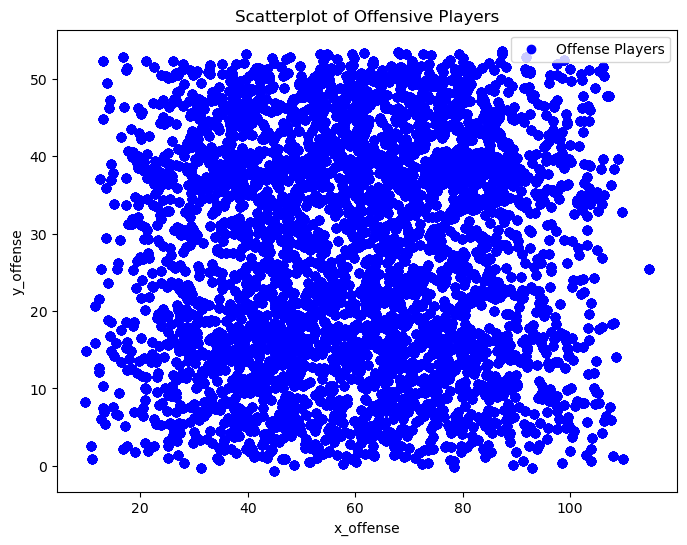

In [33]:
# Display all x_offense, y_offense
# Scatterplot 1: Displaying all x_offense, y_offense
plt.figure(figsize=(8, 6))
plt.scatter(defensive_players['x_offense'], defensive_players['y_offense'], c='blue', label='Offense Players')
plt.title('Scatterplot of Offensive Players')
plt.xlabel('x_offense')
plt.ylabel('y_offense')
plt.legend()
plt.show()

In [34]:
print(defensive_players[['x_offense','y_offense']].value_counts())
len(defensive_players[(defensive_players['x_offense']==84.88)&(defensive_players['y_offense']==7.19)])


x_offense  y_offense
84.88      7.19         22
87.58      10.39        22
70.87      45.99        11
70.76      28.24        11
70.80      46.53        11
                        ..
48.60      45.87        11
48.61      10.33        11
48.62      0.13         11
           19.59        11
114.73     25.36        11
Length: 3756, dtype: int64


22

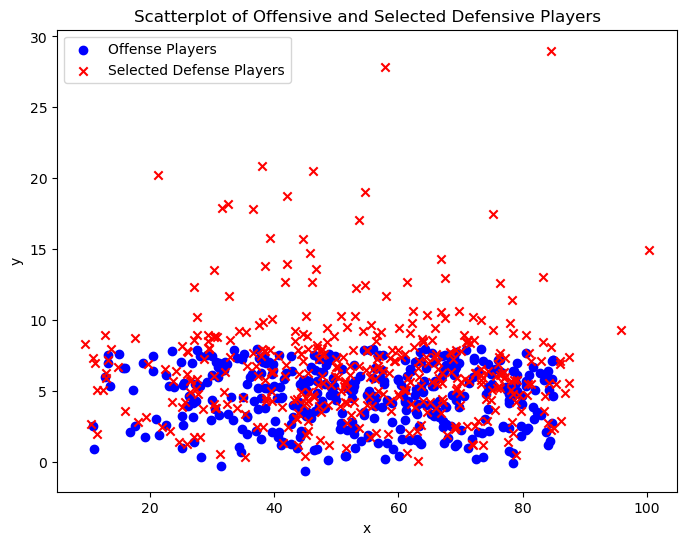

In [35]:
# Scatterplot 2: Selecting a specific x_offense, y_offense
selected_x_offense = 85 # 84.88
selected_y_offense = 8 # 7.19

selected_defense = defensive_players[(defensive_players['x_offense'] < selected_x_offense) 
                                     & (defensive_players['y_offense'] < selected_y_offense)
                                     & (defensive_players['tackle_prob'] == 1)]

plt.figure(figsize=(8, 6))
plt.scatter(selected_defense['x_offense'], selected_defense['y_offense'], c='blue', label='Offense Players')
plt.scatter(selected_defense['x_defense'], selected_defense['y_defense'], c='red', label='Selected Defense Players', marker='x')
plt.title('Scatterplot of Offensive and Selected Defensive Players')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Modeling

## Logistic Regression

In [214]:
# Handling missing values if any
selected_data.dropna(inplace=True)
#understand which na values are being dropped

# Splitting the data into training and testing sets
train = selected_data[selected_data["week"] != 7]
test = selected_data[selected_data["week"] == 7]

#train = train.drop(columns=non_significant_features)
#test = test.drop(columns=non_significant_features)

# others = [
#     'offense_score', 'defense_score', 'dir_offense', 'o_offense', 'assist', 'dir_defense', 'o_defense',
#     'playDirection_left', 'playDirection_right', 'position_group_offense_HB', 'position_group_offense_QB', 
#     'position_group_offense_R', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'quarter_5', 'down_1', 
#     'down_2', 'down_3', 'down_4', 'offenseFormation_EMPTY', 'offenseFormation_I_FORM', 'offenseFormation_JUMBO', 
#     'offenseFormation_PISTOL', 'offenseFormation_SHOTGUN', 'offenseFormation_SINGLEBACK', 'offenseFormation_WILDCAT',
#     'position_group_defense_LB', 'position_group_defense_DL', 'position_group_defense_DB', 'defense_score', 
#     'offense_score', 'forcedFumble', 'assist'
# ]

# others = [
#     #'offense_score', 'defense_score', 'dir_offense', 'o_offense', 'assist', 'dir_defense', 'o_defense',
#     'playDirection_left', 'position_group_offense_QB', 
#     'position_group_offense_R', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'down_1', 
#     'down_2', 'down_3', 'offenseFormation_EMPTY', 'offenseFormation_I_FORM', 'offenseFormation_JUMBO', 
#     'offenseFormation_PISTOL', 'offenseFormation_SHOTGUN', 'offenseFormation_SINGLEBACK'
# ]

# train = train.drop(columns=others)
# test = test.drop(columns=others)

# Remove week column
train = train.drop(columns=['week'])
test = test.drop(columns=['week'])

X_train = train.drop(columns=['tackle_prob'], axis=1)
X_test = test.drop(columns=['tackle_prob'], axis=1)
y_train = train['tackle_prob']
y_test = test['tackle_prob']

# X_train = X_train[['o_offense', 'a_offense', 's_offense', 'a_defense', 's_defense']]
# X_test = X_test[['o_offense', 'a_offense', 's_offense', 'a_defense', 's_defense']]

# X_train = X_train.drop(columns = ['game_rolling_missed_tackle_ct','season_rolling_missed_tackle_ct', 'game_rolling_tackle_ct', 'season_rolling_tackle_ct'])
# X_test = X_test.drop(columns = ['game_rolling_missed_tackle_ct','season_rolling_missed_tackle_ct', 'game_rolling_tackle_ct', 'season_rolling_tackle_ct'])

print("Number of tackles in test set:")
print(y_test.value_counts())


# Initializing and training the logistic regression model
model = LogisticRegression(random_state=2, max_iter=5000, penalty='l2', C=1.0)
model.fit(X_train, y_train)

Number of tackles in test set:
0    4980
1     498
Name: tackle_prob, dtype: int64


C:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=5000, random_state=2)

In [215]:
# Extract playId and gameId for week 7 to later find player with highest prob of tackle
defensive_players_week7 = defensive_players[defensive_players['week'] == 7][['gameId', 'playId']]

# Concatenate X_test and defensive_players_week7ii
results = X_test.copy()
results = pd.concat([results, defensive_players_week7], axis=1)

# Making predictions on the test set
results["y_test"] = y_test
results['y_prob'] = model.predict_proba(X_test)[:, 1]
results["y_prob_rank"] = results.groupby(by=(['playId','gameId']))['y_prob'].rank(ascending=False)
results["y_pred"] = np.where(results["y_prob_rank"] == 1, 1, 0)


# Evaluating the model
accuracy = accuracy_score(y_test, results["y_pred"])
classification_report_result = classification_report(y_test, results["y_pred"])

# Displaying the results
print(f"Accuracy: {accuracy:}")
print("Classification Report:\n", classification_report_result)

Accuracy: 0.9350127783862724
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      4980
           1       0.64      0.64      0.64       498

    accuracy                           0.94      5478
   macro avg       0.80      0.80      0.80      5478
weighted avg       0.94      0.94      0.94      5478



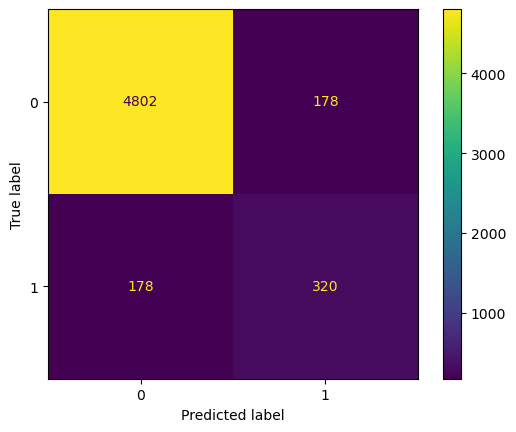

In [216]:
cm = confusion_matrix(y_test, results["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

In [217]:
# LOOK AT AUC

from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Compute AUC-ROC
auc_roc = roc_auc_score(results["y_test"], results["y_pred"])

# Displaying the results
print(f"AUC is: {auc_roc:}")


AUC is: 0.8034136546184739


In [218]:
# # Initializing and training the logistic regression model
# model = LogisticRegression(random_state=2, max_iter=5000, penalty='l2', C=1.0)
# model.fit(X_train, y_train)

# Adding a constant to the features for statsmodels
X_train_stats = sm.add_constant(X_train)

# Fitting logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train_stats)
result = logit_model.fit()

# Displaying the summary with coefficients and p-values
print(result.summary())



Optimization terminated successfully.
         Current function value: 0.173230
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            tackle_prob   No. Observations:                35860
Model:                          Logit   Df Residuals:                    35813
Method:                           MLE   Df Model:                           46
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                  0.4315
Time:                        01:05:36   Log-Likelihood:                -6212.0
converged:                       True   LL-Null:                       -10927.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.2987   1.68e+06   1.78e-07  

In [219]:
# Get the coefficients (weights) of the features
coefficients = model.coef_[0]

# Create a DataFrame to display feature names and their corresponding coefficients
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Coefficient': coefficients
})

# Sort the DataFrame by absolute coefficient values to see the importance
feature_importance_df['AbsoluteCoefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='AbsoluteCoefficient', ascending=False).drop('AbsoluteCoefficient', axis=1)

# Display the feature importance DataFrame
feature_importance_df

,Feature,Coefficient
34,position_group_defense_DL,-0.854614
33,position_group_defense_DB,0.584896
22,rank_to_bc,-0.527848
35,position_group_defense_LB,0.302708
19,dist_to_bc,-0.193562
...,...,...
0,o_defense,0.000182
13,dir_offense,0.000139
12,o_offense,-0.000088
5,time_remaining,0.000025


## CART

In [220]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [221]:
# Handling missing values if any
selected_data.dropna(inplace=True)

# Splitting the data into training and testing sets
train = selected_data[selected_data["week"] != 7]
test = selected_data[selected_data["week"] == 7]

# Remove week column
train = train.drop(columns=['week'])
test = test.drop(columns=['week'])


X_train = train.drop(columns=['tackle_prob'], axis=1)
X_test = test.drop(columns=['tackle_prob'], axis=1)
y_train = train['tackle_prob']
y_test = test['tackle_prob']

print("Number of tackles in test set:")
print(y_test.value_counts())

Number of tackles in test set:
0    4980
1     498
Name: tackle_prob, dtype: int64


In [222]:
# Initialize and train the CART model
cart_model = DecisionTreeClassifier(random_state=2)
cart_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=2)

In [223]:
# Extract playId and gameId for week 7 to later find player with highest prob of tackle
defensive_players_week7 = defensive_players[defensive_players['week'] == 7][['gameId', 'playId']]

# Concatenate X_test and defensive_players_week7ii
results = X_test.copy()
results = pd.concat([results, defensive_players_week7], axis=1)

# Making predictions on the test set
results["y_test"] = y_test
results['y_prob'] = cart_model.predict_proba(X_test)[:, 1]
results["y_prob_rank"] = results.groupby(by=(['playId','gameId']))['y_prob'].rank(ascending=False)
results["y_pred"] = np.where(results["y_prob_rank"] == 1, 1, 0)

# Evaluating the model
accuracy = accuracy_score(y_test, results["y_pred"])
classification_report_result = classification_report(y_test, results["y_pred"])

# Displaying the results
print(f"Accuracy: {accuracy:}")
print("Classification Report:\n", classification_report_result)

Accuracy: 0.9222343921139102
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      4980
           1       0.63      0.35      0.45       498

    accuracy                           0.92      5478
   macro avg       0.78      0.66      0.70      5478
weighted avg       0.91      0.92      0.91      5478



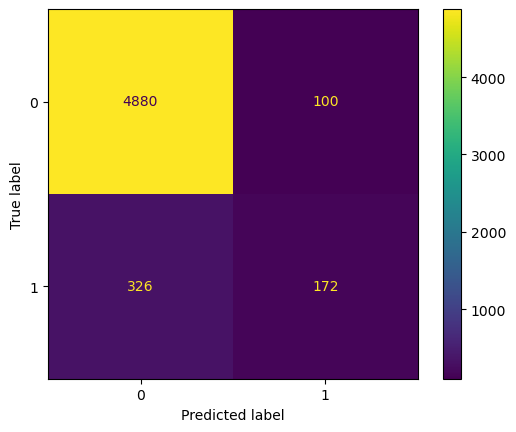

In [224]:
cm = confusion_matrix(y_test, results["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

In [225]:
# LOOK AT AUC

# Compute AUC-ROC
auc_roc = roc_auc_score(results["y_test"], results["y_pred"])

# Displaying the results
print(f"AUC is: {auc_roc:}")


AUC is: 0.6626506024096386


In [226]:
# Adding a constant to the features for statsmodels
X_train_stats = sm.add_constant(X_train)

# Fitting logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train_stats)
result = logit_model.fit()

# Displaying the summary with coefficients and p-values
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.173230
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            tackle_prob   No. Observations:                35860
Model:                          Logit   Df Residuals:                    35813
Method:                           MLE   Df Model:                           46
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                  0.4315
Time:                        01:08:07   Log-Likelihood:                -6212.0
converged:                       True   LL-Null:                       -10927.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.2987   1.68e+06   1.78e-07  

## Random Forest

In [227]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

from sklearn.metrics import accuracy_score

In [246]:
# Handling missing values if any
selected_data.dropna(inplace=True)

# Splitting the data into training and testing sets
train = selected_data[selected_data["week"] != 7]
test = selected_data[selected_data["week"] == 7]

# Remove week column
train = train.drop(columns=['week'])
test = test.drop(columns=['week'])


X_train = train.drop(columns=['tackle_prob'], axis=1)
X_test = test.drop(columns=['tackle_prob'], axis=1)
y_train = train['tackle_prob']
y_test = test['tackle_prob']

print("Number of tackles in test set:")
print(y_test.value_counts())

Number of tackles in test set:
0    4980
1     498
Name: tackle_prob, dtype: int64


In [247]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the Random Forest classifier on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [248]:
# Extract playId and gameId for week 7 to later find player with highest prob of tackle
defensive_players_week7 = defensive_players[defensive_players['week'] == 7][['gameId', 'playId']]

# Concatenate X_test and defensive_players_week7ii
results = X_test.copy()
results = pd.concat([results, defensive_players_week7], axis=1)

# Making predictions on the test set
results["y_test"] = y_test
results['y_prob'] = rf_classifier.predict_proba(X_test)[:,1]
results["y_prob_rank"] = results.groupby(by=(['playId','gameId']))['y_prob'].rank(ascending=False)
results["y_pred"] = np.where(results["y_prob_rank"] == 1, 1, 0)

# Evaluating the model
accuracy = accuracy_score(y_test, results["y_pred"])
classification_report_result = classification_report(y_test, results["y_pred"])

# Displaying the results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_result)

Accuracy: 0.9370208105147865
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4980
           1       0.65      0.65      0.65       498

    accuracy                           0.94      5478
   macro avg       0.81      0.81      0.81      5478
weighted avg       0.94      0.94      0.94      5478



In [231]:
# results[['playId', 'y_prob',"y_pred", 'y_test']].head(50)

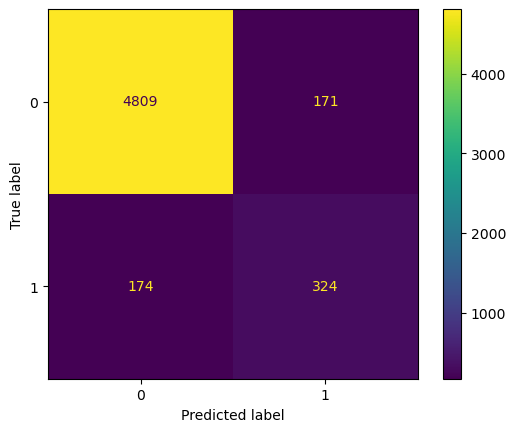

In [249]:
cm = confusion_matrix(y_test, results["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

In [250]:
# Compute AUC-ROC
auc_roc = roc_auc_score(results["y_test"], results["y_pred"])

# Displaying the results
print(f"AUC is: {auc_roc:.4f}")

AUC is: 0.8081


### Random Forest - Hyperparameter Tuning

In [234]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # Initialize the Random Forest classifier
# rf_classifier = RandomForestClassifier(random_state=42)

# # Use GridSearchCV to find the best hyperparameters
# grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

In [106]:
# # Get the best hyperparameters and the best model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# print(f"Best parameters: {best_params}")

# # Train the best model on the entire training set
# best_model.fit(X_train, y_train)

Best parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}


RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=150, random_state=42)

In [238]:
# # Extract playId and gameId for week 7 to later find player with highest prob of tackle
# defensive_players_week7 = defensive_players[defensive_players['week'] == 7][['gameId', 'playId']]

# # Concatenate X_test and defensive_players_week7ii
# results = X_test.copy()
# results = pd.concat([results, defensive_players_week7], axis=1)

# # Making predictions on the test set
# results["y_test"] = y_test
# results['y_prob'] = best_model.predict_proba(X_test)[:, 1]
# results["y_prob_rank"] = results.groupby(by=(['playId','gameId']))['y_prob'].rank(ascending=False)
# results["y_pred"] = np.where(results["y_prob_rank"] == 1, 1, 0)

# # Evaluating the model
# accuracy = accuracy_score(y_test, results["y_pred"])
# classification_report_result = classification_report(y_test, results["y_pred"])

# # Displaying the results
# print(f"Accuracy: {accuracy}")
# print("Classification Report:\n", classification_report_result)

In [235]:
# Best hyperparameters
best_max_depth = 20
best_max_features = 'log2'
best_min_samples_leaf = 4
best_min_samples_split = 10
best_n_estimators = 150

# Initialize the Random Forest classifier with the best hyperparameters
best_rf_classifier = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    max_features=best_max_features,
    random_state=42
)

# Fit the Random Forest
best_rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=150, random_state=42)

In [240]:
# Extract playId and gameId for week 7 to later find player with highest prob of tackle
defensive_players_week7 = defensive_players[defensive_players['week'] == 7][['gameId', 'playId']]

# Concatenate X_test and defensive_players_week7ii
results = X_test.copy()
results = pd.concat([results, defensive_players_week7], axis=1)

# Making predictions on the test set
results["y_test"] = y_test
results['y_prob'] = best_rf_classifier.predict_proba(X_test)[:, 1]
results["y_prob_rank"] = results.groupby(by=(['playId','gameId']))['y_prob'].rank(ascending=False)
results["y_pred"] = np.where(results["y_prob_rank"] == 1, 1, 0)

# Evaluating the model
accuracy = accuracy_score(y_test, results["y_pred"])
classification_report_result = classification_report(y_test, results["y_pred"])

# Displaying the results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_result)

Accuracy: 0.9375684556407448
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4980
           1       0.66      0.66      0.66       498

    accuracy                           0.94      5478
   macro avg       0.81      0.81      0.81      5478
weighted avg       0.94      0.94      0.94      5478



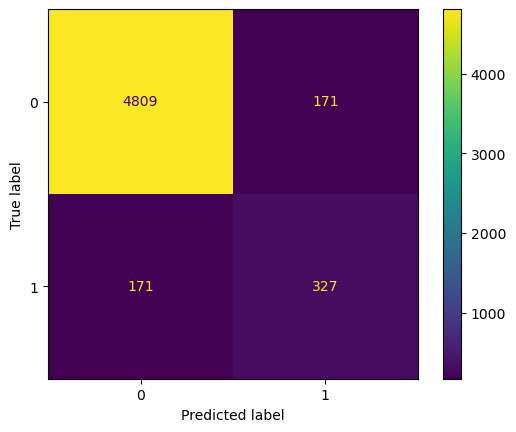

In [241]:
cm = confusion_matrix(y_test, results["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

In [242]:
# Compute AUC-ROC
auc_roc = roc_auc_score(results["y_test"], results["y_pred"])

# Displaying the results
print(f"AUC is: {auc_roc:.4f}")

AUC is: 0.8111


Top Features:
                      Feature  Importance
22                 rank_to_bc    0.213316
19                 dist_to_bc    0.186262
21      total_weight_blockers    0.067777
20               num_blockers    0.061807
24                    delta_y    0.058586
..                        ...         ...
44                     down_4    0.000131
40                  quarter_5    0.000093
31  position_group_offense_QB    0.000031
47     offenseFormation_JUMBO    0.000014
51   offenseFormation_WILDCAT    0.000000

[52 rows x 2 columns]


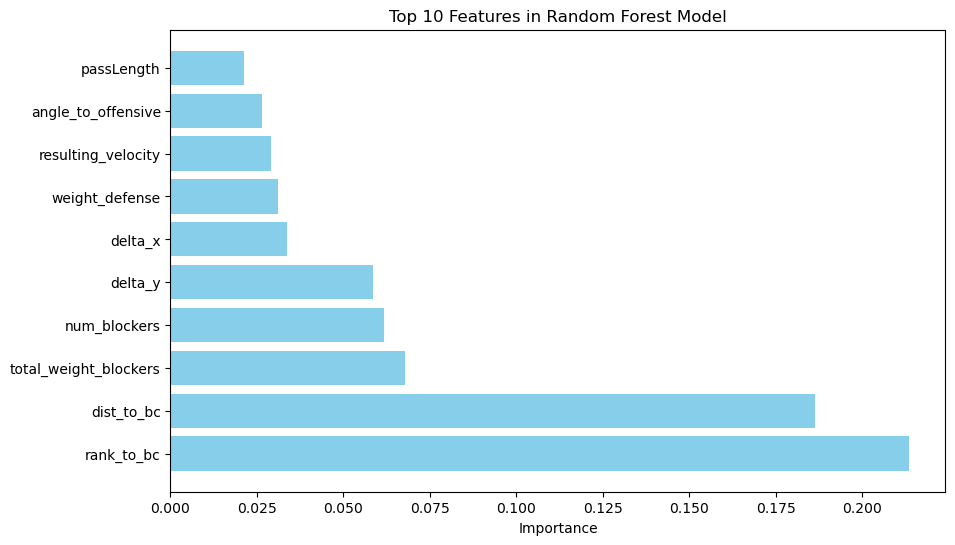

In [244]:
# Get feature importances
feature_importances = best_rf_classifier.feature_importances_

# Create a DataFrame to better visualize the results
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print("Top Features:")
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Features in Random Forest Model')
plt.show()

### Random Forest - Drop insignificant features

Accuracy: 0.9372033588901059
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4980
           1       0.65      0.65      0.65       498

    accuracy                           0.94      5478
   macro avg       0.81      0.81      0.81      5478
weighted avg       0.94      0.94      0.94      5478

AUC is: 0.8100


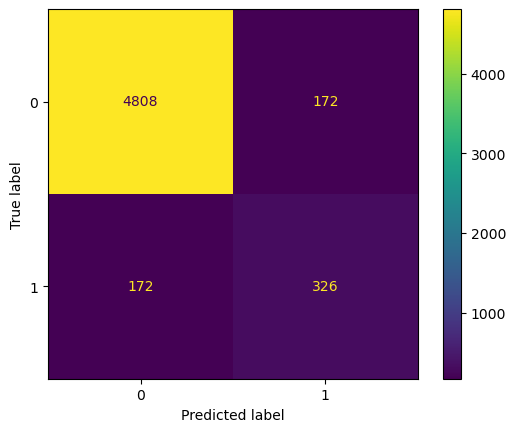

In [245]:
# DROPPING INSIGNIFICANT FEATURES

# Set Threshold
threshold = 0.01

# Identify non-significant features
non_significant_features = feature_importance_df[feature_importance_df['Importance'] < threshold]['Feature']

# Drop non-significant features from the training and test sets
X_train_reduced = X_train.drop(columns=non_significant_features)
X_test_reduced = X_test.drop(columns=non_significant_features)

# Best hyperparameters
best_max_depth = 20
best_max_features = 'log2'
best_min_samples_leaf = 4
best_min_samples_split = 10
best_n_estimators = 150

# Initialize the Random Forest classifier with the best hyperparameters
rf_classifier_reduced = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    max_features=best_max_features,
    random_state=42
)

rf_classifier_reduced.fit(X_train_reduced, y_train)

# # Evaluate the model's performance on the test set
# accuracy_reduced = rf_classifier_reduced.score(X_test_reduced, y_test)


# Extract playId and gameId for week 7 to later find player with highest prob of tackle
defensive_players_week7 = defensive_players[defensive_players['week'] == 7][['gameId', 'playId']]

# Concatenate X_test and defensive_players_week7ii
results = X_test.copy()
results_drop = results.drop(columns=non_significant_features)
results = pd.concat([results_drop, defensive_players_week7], axis=1)

# Making predictions on the test set
results["y_test"] = y_test
results['y_prob'] = rf_classifier_reduced.predict_proba(results_drop)[:, 1]
results["y_prob_rank"] = results.groupby(by=(['playId','gameId']))['y_prob'].rank(ascending=False)
results["y_pred"] = np.where(results["y_prob_rank"] == 1, 1, 0)

# Evaluating the model
accuracy = accuracy_score(y_test, results["y_pred"])
classification_report_result = classification_report(y_test, results["y_pred"])

# Displaying the results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_result)

cm = confusion_matrix(y_test, results["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

# Compute AUC-ROC
auc_roc = roc_auc_score(results["y_test"], results["y_pred"])

# Displaying the results
print(f"AUC is: {auc_roc:.4f}")


# XGBoost

### XGBoost - Raw

In [251]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [252]:
# Handling missing values if any
selected_data.dropna(inplace=True)

# Splitting the data into training and testing sets
train = selected_data[selected_data["week"] != 7]
test = selected_data[selected_data["week"] == 7]

# Remove week column
train = train.drop(columns=['week'])
test = test.drop(columns=['week'])


X_train = train.drop(columns=['tackle_prob'], axis=1)
X_test = test.drop(columns=['tackle_prob'], axis=1)
y_train = train['tackle_prob']
y_test = test['tackle_prob']

print("Number of tackles in test set:")
print(y_test.value_counts())

Number of tackles in test set:
0    4980
1     498
Name: tackle_prob, dtype: int64


In [253]:
# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

# Train the XGBoost classifier on the training data
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [254]:
# Extract playId and gameId for week 7 to later find player with highest prob of tackle
defensive_players_week7 = defensive_players[defensive_players['week'] == 7][['gameId', 'playId']]

# Concatenate X_test and defensive_players_week7ii
results = X_test.copy()
results = pd.concat([results, defensive_players_week7], axis=1)

# Making predictions on the test set
results["y_test"] = y_test
results['y_prob'] = xgb_classifier.predict_proba(X_test)[:, 1]
results["y_prob_rank"] = results.groupby(by=(['playId','gameId']))['y_prob'].rank(ascending=False)
results["y_pred"] = np.where(results["y_prob_rank"] == 1, 1, 0)

# Evaluating the model
accuracy = accuracy_score(y_test, results["y_pred"])
classification_report_result = classification_report(y_test, results["y_pred"])

# Displaying the results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_result)

Accuracy: 0.9382986491420227
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4980
           1       0.66      0.66      0.66       498

    accuracy                           0.94      5478
   macro avg       0.81      0.81      0.81      5478
weighted avg       0.94      0.94      0.94      5478



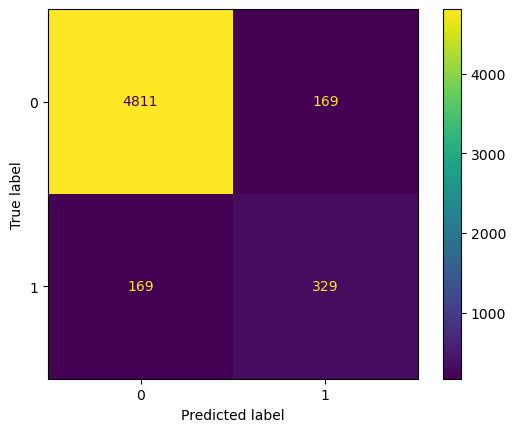

In [255]:
cm = confusion_matrix(y_test, results["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

In [256]:
# Compute AUC-ROC
auc_roc = roc_auc_score(results["y_test"], results["y_pred"])

# Displaying the results
print(f"AUC is: {auc_roc:.4f}")

AUC is: 0.8134


### XGBoost - Hyperparameter Tuning - Simple (best)

In [262]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split

# param_grid = {
#     'learning_rate': [0.01, 0.1],
#     'n_estimators': [50, 100],
#     'max_depth': [3, 4],
#     'min_child_weight': [1, 3],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'gamma': [0, 0.1]
# }

# # Initialize the XGBoost classifier
# xgb_classifier = xgb.XGBClassifier(seed=42)

# # Use GridSearchCV to find the best hyperparameters
# grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

In [113]:
# # Get the best hyperparameters and the best model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# print("Best Hyperparameters:", best_params)

# # Train the best model on the entire training set
# best_model.fit(X_train, y_train)

Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [258]:
# Best hyperparameters
best_colsample_bytree = 0.8
best_gamma = 0
best_learning_rate = 0.1
best_max_depth = 4
best_min_child_weight = 3
best_n_estimators = 100
best_subsample = 1.0

# Initialize the Random Forest classifier with the best hyperparameters
best_xgb_classifier = xgb.XGBClassifier(
    colsample_bytree=best_colsample_bytree,
    gamma=best_gamma,
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    n_estimators = best_n_estimators,
    subsample = best_subsample,
    random_state=42
)

# Fit the Random Forest
best_xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [259]:
# Extract playId and gameId for week 7 to later find player with highest prob of tackle
defensive_players_week7 = defensive_players[defensive_players['week'] == 7][['gameId', 'playId']]

# Concatenate X_test and defensive_players_week7ii
results = X_test.copy()
results = pd.concat([results, defensive_players_week7], axis=1)

# Making predictions on the test set
results["y_test"] = y_test
results['y_prob'] = best_xgb_classifier.predict_proba(X_test)[:, 1]
results["y_prob_rank"] = results.groupby(by=(['playId','gameId']))['y_prob'].rank(ascending=False)
results["y_pred"] = np.where(results["y_prob_rank"] == 1, 1, 0)

# Evaluating the model
accuracy = accuracy_score(y_test, results["y_pred"])
classification_report_result = classification_report(y_test, results["y_pred"])

# Displaying the results
print(f"Accuracy: {accuracy}")
print("Best Hyperparameters:", best_params)
print("Classification Report:\n", classification_report_result)

Accuracy: 0.9372033588901059
Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 150, 'subsample': 1.0}
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4980
           1       0.65      0.65      0.65       498

    accuracy                           0.94      5478
   macro avg       0.81      0.81      0.81      5478
weighted avg       0.94      0.94      0.94      5478



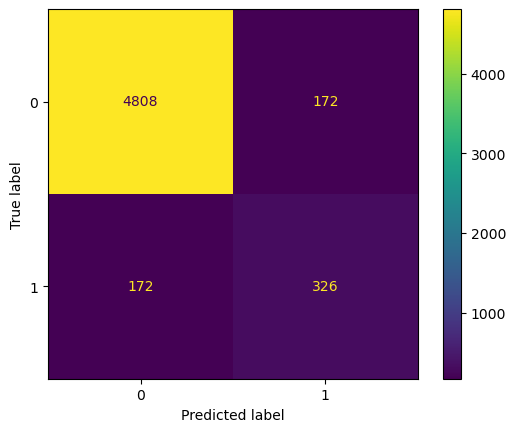

In [260]:
cm = confusion_matrix(y_test, results["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

In [261]:
# Compute AUC-ROC
auc_roc = roc_auc_score(results["y_test"], results["y_pred"])

# Displaying the results
print(f"AUC is: {auc_roc:.4f}")

AUC is: 0.8100


### XGBoost - hyperparameter tuning - Advanced

In [117]:
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [50, 100, 150],
#     'max_depth': [3, 4, 5],
#     'min_child_weight': [1, 3, 5],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'gamma': [0, 0.1, 0.2]
# }

# # Initialize the XGBoost classifier
# xgb_classifier = xgb.XGBClassifier(seed=42)

# # Use GridSearchCV to find the best hyperparameters
# grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 150],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy')

In [118]:
# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

# Train the best model on the entire training set
best_model.fit(X_train, y_train)

Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 150, 'subsample': 1.0}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [263]:
# Best hyperparameters
best_colsample_bytree = 0.8
best_gamma = 0
best_learning_rate = 0.1
best_max_depth = 5
best_min_child_weight = 3
best_n_estimators = 150
best_subsample = 1.0

# Initialize the Random Forest classifier with the best hyperparameters
best_xgb_classifier = xgb.XGBClassifier(
    colsample_bytree=best_colsample_bytree,
    gamma=best_gamma,
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    n_estimators = best_n_estimators,
    subsample = best_subsample,
    random_state=42
)

# Fit the Random Forest
best_xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [264]:
# Extract playId and gameId for week 7 to later find player with highest prob of tackle
defensive_players_week7 = defensive_players[defensive_players['week'] == 7][['gameId', 'playId']]

# Concatenate X_test and defensive_players_week7ii
results = X_test.copy()
results = pd.concat([results, defensive_players_week7], axis=1)

# Making predictions on the test set
results["y_test"] = y_test
results['y_prob'] = best_xgb_classifier.predict_proba(X_test)[:, 1]
results["y_prob_rank"] = results.groupby(by=(['playId','gameId']))['y_prob'].rank(ascending=False)
results["y_pred"] = np.where(results["y_prob_rank"] == 1, 1, 0)

# Evaluating the model
accuracy = accuracy_score(y_test, results["y_pred"])
classification_report_result = classification_report(y_test, results["y_pred"])

# Displaying the results
print(f"Accuracy: {accuracy}")
print("Best Hyperparameters:", best_params)
print("Classification Report:\n", classification_report_result)

Accuracy: 0.9397590361445783
Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 150, 'subsample': 1.0}
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4980
           1       0.67      0.67      0.67       498

    accuracy                           0.94      5478
   macro avg       0.82      0.82      0.82      5478
weighted avg       0.94      0.94      0.94      5478



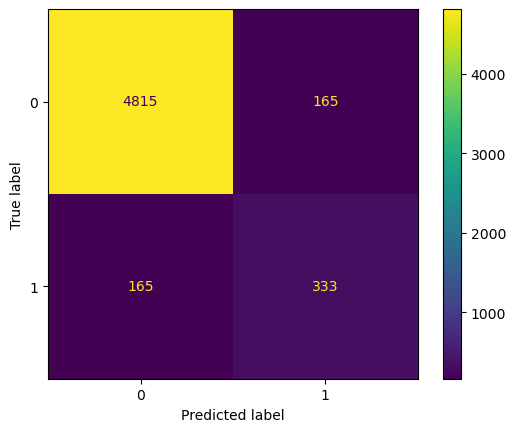

In [265]:
cm = confusion_matrix(y_test, results["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

In [266]:
# Compute AUC-ROC
auc_roc = roc_auc_score(results["y_test"], results["y_pred"])

# Displaying the results
print(f"AUC is: {auc_roc:.4f}")

AUC is: 0.8178


# Ensemble - XGBoost and RF

In [ ]:
# Predicts 1 if RF predicts true negative (0) and XGBoost predicts True positive (1)

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix


combined_predictions = np.logical_and(rf_predictions == 0, xgb_predictions == 1)

# Evaluate the combined model
combined_accuracy = accuracy_score(y_test, combined_predictions)
combined_auc = roc_auc_score(y_test, combined_predictions)
combined_conf_matrix = confusion_matrix(y_test, combined_predictions)

# Print results
print(f"Combined Model Accuracy: {combined_accuracy:.4f}")
print(f"Combined Model AUC: {combined_auc:.4f}")
print("Combined Model Confusion Matrix:")
print(combined_conf_matrix)

In [ ]:
# Create individual models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(n_estimators=100, random_state=42)

# Create a voting classifier
ensemble_model = VotingClassifier(estimators=[
    ('Random Forest', rf_model),
    ('XGBoost', xgb_model)
], voting='soft')  # 'soft' enables probability averaging

# Fit the ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions
y_pred = ensemble_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Ensemble Model Accuracy: {accuracy}')

# Other

In [267]:
from tabulate import tabulate

# Data
data = [
    ["Logistic", "", 0.9350, 0.8034, 4802, 320],
    ["CART", "", 0.9222, 0.6627, 4880, 172],
    ["RF", "Raw", 0.9370, 0.8081, 4809, 324],
    ["RF", "Tuned", 0.9376, 0.8111, 4809, 327],
    ["RF", "Tuned and drop non-sig", 0.9372, 0.8100, 4808, 326],
    ["XGBoost", "Raw", 0.9383, 0.8134, 4811, 329],
    ["XGBoost", "Tuned simple", 0.9372, 0.8100, 4808, 326],
    ["XGBoost", "Tuned complex", 0.9398, 0.8178, 4815, 333],
]

# Headers
headers = ["Model", "Notes", "Accuracy", "AUC", "TN", "TP"]

# Create and print the table
table = tabulate(data, headers, tablefmt="fancy_grid")
print(table)


╒══════════╤════════════════════════╤════════════╤════════╤══════╤══════╕
│ Model    │ Notes                  │   Accuracy │    AUC │   TN │   TP │
╞══════════╪════════════════════════╪════════════╪════════╪══════╪══════╡
│ Logistic │                        │     0.935  │ 0.8034 │ 4802 │  320 │
├──────────┼────────────────────────┼────────────┼────────┼──────┼──────┤
│ CART     │                        │     0.9222 │ 0.6627 │ 4880 │  172 │
├──────────┼────────────────────────┼────────────┼────────┼──────┼──────┤
│ RF       │ Raw                    │     0.937  │ 0.8081 │ 4809 │  324 │
├──────────┼────────────────────────┼────────────┼────────┼──────┼──────┤
│ RF       │ Tuned                  │     0.9376 │ 0.8111 │ 4809 │  327 │
├──────────┼────────────────────────┼────────────┼────────┼──────┼──────┤
│ RF       │ Tuned and drop non-sig │     0.9372 │ 0.81   │ 4808 │  326 │
├──────────┼────────────────────────┼────────────┼────────┼──────┼──────┤
│ XGBoost  │ Raw                    │ 

In [317]:
pd.set_option('display.max_rows', None)
defensive_players[defensive_players['nflId_defense']==38577.0][['gameId', 'playId','nflId_defense','season_rolling_tackle_ct','season_rolling_missed_tackle_ct', 'game_rolling_tackle_ct', 'game_rolling_missed_tackle_ct', 'tackle_prob']]

,gameId,playId,nflId_defense,season_rolling_tackle_ct,season_rolling_missed_tackle_ct,game_rolling_tackle_ct,game_rolling_missed_tackle_ct,tackle_prob
0,2022090800,56,38577.0,0.0,0.0,0.0,0.0,0
11,2022090800,122,38577.0,1.0,0.0,1.0,0.0,1
22,2022090800,167,38577.0,0.0,0.0,0.0,0.0,0
33,2022090800,212,38577.0,2.0,0.0,2.0,0.0,1
44,2022090800,236,38577.0,0.0,0.0,0.0,0.0,0
55,2022090800,569,38577.0,0.0,0.0,0.0,0.0,0
66,2022090800,593,38577.0,0.0,0.0,0.0,0.0,0
77,2022090800,617,38577.0,0.0,0.0,0.0,0.0,0
88,2022090800,646,38577.0,0.0,0.0,0.0,0.0,0
99,2022090800,692,38577.0,3.0,0.0,3.0,0.0,1


In [195]:
results_krish = results.copy()

# Extract playId and gameId for week 7 to later find player with highest prob of tackle
defensive_players_week7_names = defensive_players[defensive_players['week'] == 7][['homeTeamAbbr','visitorTeamAbbr','displayName_x_defense','quarter','gameClock']]

# Concatenate X_test and defensive_players_week7ii
results_krish_name = pd.concat([results_krish, defensive_players_week7_names], axis=1)
results_krish_name_dog = results_krish_name[['gameId', 'playId','homeTeamAbbr','visitorTeamAbbr','quarter','gameClock','displayName_x_defense', 'y_prob','y_prob_rank','y_pred','y_test']]

In [ ]:
results_krish_name[results_krish_name['y_test']==1].sort_values('y_prob')

In [170]:
results_krish_name[(results_krish_name['y_test']==1)&(results_krish_name['y_prob']<0.1)].groupby('displayName_x_defense').count().sort_values('y_test')

,gameId,playId,homeTeamAbbr,visitorTeamAbbr,quarter,gameClock,y_prob,y_prob_rank,y_pred,y_test
displayName_x_defense,,,,,,,,,,
Adoree' Jackson,1,1,1,1,1,1,1,1,1,1
Levi Wallace,1,1,1,1,1,1,1,1,1,1
Khalen Saunders,1,1,1,1,1,1,1,1,1,1
Kevin Byard,1,1,1,1,1,1,1,1,1,1
Kerby Joseph,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
Derek Stingley,2,2,2,2,2,2,2,2,2,2
Jevon Holland,2,2,2,2,2,2,2,2,2,2
Jayron Kearse,2,2,2,2,2,2,2,2,2,2


In [191]:
playid_missed[playid_missed['pff_missedTackle'] > 0][['gameId', 'playId']]

,gameId,playId
9,2022102000,1025
10,2022102000,1182
11,2022102000,1277
20,2022102000,2556
31,2022102000,3622
...,...,...
476,2022102400,238
487,2022102400,2513
490,2022102400,2866
495,2022102400,3492


In [201]:
results_krish_name

,o_defense,dir_defense,height_in_inch_defense,weight_defense,yardsToGo,time_remaining,passLength,defendersInTheBox,pff_missedTackle,season_rolling_tackle_ct,game_rolling_tackle_ct,season_rolling_missed_tackle_ct,game_rolling_missed_tackle_ct,o_offense,dir_offense,weight_offense,height_in_inch_offense,offense_score,defense_score,defense_win_prob,dist_to_bc,num_blockers,total_weight_blockers,rank_to_bc,delta_x,delta_y,angle_to_offensive,resulting_velocity,resulting_acceleration,playDirection_left,playDirection_right,position_group_offense_HB,position_group_offense_QB,position_group_offense_R,position_group_defense_DB,position_group_defense_DL,position_group_defense_LB,quarter_1,quarter_2,quarter_3,quarter_4,quarter_5,down_1,down_2,down_3,down_4,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_JUMBO,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT,gameId,playId,y_test,y_prob,y_prob_rank,y_pred,homeTeamAbbr,visitorTeamAbbr,displayName_x_defense,quarter,gameClock
35860,184.91,174.33,70,195,10,3600,5.0,7.0,0.0,12.0,0.0,3.0,0.0,274.34,337.00,231,76,0,0,0.554282,16.684355,8,2196,8.0,4.34,-16.11,-74.922584,-1.020237,-0.641190,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2022102000,56,0,0.000527,8.0,0,ARI,NO,Budda Baker,1,15:00
35861,213.97,233.71,71,190,10,3600,5.0,7.0,0.0,15.0,0.0,0.0,0.0,274.34,337.00,231,76,0,0,0.554282,24.583558,9,2417,11.0,13.23,-20.72,-57.441219,1.151050,0.948985,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2022102000,56,0,0.001614,4.0,0,ARI,NO,Byron Murphy,1,15:00
35862,197.08,229.14,76,281,10,3600,5.0,7.0,0.0,1.0,0.0,0.0,0.0,274.34,337.00,231,76,0,0,0.554282,11.073518,3,943,5.0,-9.32,-5.98,-147.314515,1.217987,0.115085,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2022102000,56,0,0.000232,10.0,0,ARI,NO,Zach Allen,1,15:00
35863,133.87,227.13,71,190,10,3600,5.0,7.0,0.0,19.0,0.0,1.0,0.0,274.34,337.00,231,76,0,0,0.554282,20.872769,9,2417,10.0,20.86,-0.73,-2.004260,-1.033776,-3.768703,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2022102000,56,0,0.006849,3.0,0,ARI,NO,Jalen Thompson,1,15:00
35864,235.63,175.76,75,225,10,3600,5.0,7.0,0.0,11.0,0.0,2.0,0.0,274.34,337.00,231,76,0,0,0.554282,15.444695,7,2011,7.0,-14.15,-6.19,-156.372746,3.995829,2.811225,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2022102000,56,0,0.001332,6.0,0,ARI,NO,Isaiah Simmons,1,15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41333,75.39,113.13,72,195,10,224,0.0,4.0,0.0,5.0,2.0,1.0,0.0,118.05,162.22,246,72,14,33,0.996346,10.191173,3,981,4.0,7.50,6.90,42.614056,1.544311,0.700444,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,2022102400,3556,0,0.187695,2.0,0,NE,CHI,Jaylon Johnson,4,3:44
41334,174.30,161.77,71,190,10,224,0.0,4.0,0.0,9.0,1.0,1.0,0.0,118.05,162.22,246,72,14,33,0.996346,33.685608,10,2732,11.0,13.39,-30.91,-66.578070,-1.003552,-1.488712,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,2022102400,3556,0,0.000576,11.0,0,NE,CHI,Kindle Vildor,4,3:44
41335,101.52,128.75,72,195,10,224,0.0,4.0,0.0,18.0,0.0,3.0,1.0,118.05,162.22,246,72,14,33,0.996346,5.993630,0,0,1.0,5.94,0.80,7.670448,-3.422590,-0.660771,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,2022102400,3556,0,0.923748,1.0,1,NE,CHI,Kyler Gordon,4,3:44
41336,118.83,174.90,73,202,10,224,0.0,4.0,0.0,10.0,2.0,2.0,0.0,118.05,162.22,246,72,14,33,0.996346,29.492041,9,2552,10.0,24.26,-16.77,-34.654606,-3.705714,-2.548766,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,2022102400,3556,0,0.005208,7.0,0,NE,CHI,Jaquan Brisker,4,3:44


In [196]:
playid_missed = results_krish_name.groupby(['gameId','playId'])['pff_missedTackle'].sum().reset_index()
#playid_missed[playid_missed['pff_missedTackle'] > 0][['gameId','playId']]

# Assuming 'gameId' and 'playId' are common columns in both DataFrames
filtered_results = results_krish_name.merge(
    playid_missed[playid_missed['pff_missedTackle'] > 0][['gameId', 'playId']],
    on=['gameId', 'playId'],
    how='left',
    indicator=True
)

# Keep only the rows where the indicator is set to 'left_only', meaning they are not present in playid_missed
filtered_results = filtered_results[filtered_results['_merge'] == 'left_only']

# Drop the indicator column
filtered_results = filtered_results.drop('_merge', axis=1)
filtered_results
# Now, filtered_results contains only the rows that are not in playid_missed


,o_defense,dir_defense,height_in_inch_defense,weight_defense,yardsToGo,time_remaining,passLength,defendersInTheBox,pff_missedTackle,season_rolling_tackle_ct,game_rolling_tackle_ct,season_rolling_missed_tackle_ct,game_rolling_missed_tackle_ct,o_offense,dir_offense,weight_offense,height_in_inch_offense,offense_score,defense_score,defense_win_prob,dist_to_bc,num_blockers,total_weight_blockers,rank_to_bc,delta_x,delta_y,angle_to_offensive,resulting_velocity,resulting_acceleration,playDirection_left,playDirection_right,position_group_offense_HB,position_group_offense_QB,position_group_offense_R,position_group_defense_DB,position_group_defense_DL,position_group_defense_LB,quarter_1,quarter_2,quarter_3,quarter_4,quarter_5,down_1,down_2,down_3,down_4,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_JUMBO,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT,gameId,playId,y_test,y_prob,y_prob_rank,y_pred,homeTeamAbbr,visitorTeamAbbr,displayName_x_defense,quarter,gameClock
0,184.91,174.33,70,195,10,3600,5.0,7.0,0.0,12.0,0.0,3.0,0.0,274.34,337.00,231,76,0,0,0.554282,16.684355,8,2196,8.0,4.34,-16.11,-74.922584,-1.020237,-0.641190,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2022102000,56,0,0.000527,8.0,0,ARI,NO,Budda Baker,1,15:00
1,213.97,233.71,71,190,10,3600,5.0,7.0,0.0,15.0,0.0,0.0,0.0,274.34,337.00,231,76,0,0,0.554282,24.583558,9,2417,11.0,13.23,-20.72,-57.441219,1.151050,0.948985,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2022102000,56,0,0.001614,4.0,0,ARI,NO,Byron Murphy,1,15:00
2,197.08,229.14,76,281,10,3600,5.0,7.0,0.0,1.0,0.0,0.0,0.0,274.34,337.00,231,76,0,0,0.554282,11.073518,3,943,5.0,-9.32,-5.98,-147.314515,1.217987,0.115085,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2022102000,56,0,0.000232,10.0,0,ARI,NO,Zach Allen,1,15:00
3,133.87,227.13,71,190,10,3600,5.0,7.0,0.0,19.0,0.0,1.0,0.0,274.34,337.00,231,76,0,0,0.554282,20.872769,9,2417,10.0,20.86,-0.73,-2.004260,-1.033776,-3.768703,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2022102000,56,0,0.006849,3.0,0,ARI,NO,Jalen Thompson,1,15:00
4,235.63,175.76,75,225,10,3600,5.0,7.0,0.0,11.0,0.0,2.0,0.0,274.34,337.00,231,76,0,0,0.554282,15.444695,7,2011,7.0,-14.15,-6.19,-156.372746,3.995829,2.811225,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2022102000,56,0,0.001332,6.0,0,ARI,NO,Isaiah Simmons,1,15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5462,348.19,295.73,72,195,1,244,18.0,3.0,0.0,5.0,2.0,1.0,0.0,116.94,235.88,180,75,14,33,0.996331,27.796181,8,2202,11.0,-4.31,27.46,98.920118,-2.412319,-2.469756,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,2022102400,3527,0,0.000587,8.0,0,NE,CHI,Jaylon Johnson,4,4:04
5463,154.52,228.96,71,190,1,244,18.0,3.0,0.0,9.0,1.0,1.0,0.0,116.94,235.88,180,75,14,33,0.996331,7.311833,1,200,2.0,6.02,-4.15,-34.581167,-0.491578,-0.492703,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,2022102400,3527,0,0.333601,2.0,0,NE,CHI,Kindle Vildor,4,4:04
5464,197.58,202.78,72,195,1,244,18.0,3.0,0.0,18.0,0.0,3.0,1.0,116.94,235.88,180,75,14,33,0.996331,9.460576,1,200,4.0,-8.84,3.37,159.132067,2.518109,2.120132,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,2022102400,3527,0,0.007097,4.0,0,NE,CHI,Kyler Gordon,4,4:04
5465,23.17,351.93,73,202,1,244,18.0,3.0,0.0,10.0,2.0,2.0,0.0,116.94,235.88,180,75,14,33,0.996331,18.715707,2,450,6.0,9.09,16.36,60.942422,1.869624,1.443407,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,2022102400,3527,0,0.003558,6.0,0,NE,CHI,Jaquan Brisker,4,4:04


In [202]:
joe_filter = filtered_results[['gameId', 'playId','homeTeamAbbr','visitorTeamAbbr','quarter','gameClock','displayName_x_defense', 'y_prob','y_prob_rank','y_pred','y_test']].sort_values('y_prob')

In [19]:
joe_filter[joe_filter['y_test']==1].sort_values('y_prob').head(10)

NameError: name 'joe_filter' is not defined

In [171]:
results_krish_name[(results_krish_name['y_test']==1)&(results_krish_name['displayName_x_defense']=='Jonathan Owens')].sort_values('y_prob')

,gameId,playId,homeTeamAbbr,visitorTeamAbbr,quarter,gameClock,displayName_x_defense,y_prob,y_prob_rank,y_pred,y_test
39516,2022102308,2416,LV,HOU,3,2:03,Jonathan Owens,0.014371,3.0,0,1
39229,2022102308,185,LV,HOU,1,12:37,Jonathan Owens,0.051048,2.0,0,1
39372,2022102308,1084,LV,HOU,2,9:58,Jonathan Owens,0.056134,3.0,0,1
39526,2022102308,2440,LV,HOU,3,1:20,Jonathan Owens,0.083039,2.0,0,1
39482,2022102308,2116,LV,HOU,3,6:39,Jonathan Owens,0.418848,1.0,1,1
39571,2022102308,2813,LV,HOU,4,10:36,Jonathan Owens,0.774002,1.0,1,1
39240,2022102308,209,LV,HOU,1,11:53,Jonathan Owens,0.916238,1.0,1,1
